In [1]:
#############################################################
#        Hurricane and Severe Storm Sentinel (HS3) Global Hawk 
#        Cloud Physics Lidar (CPL) Python Quickview
#
#        Decription: This code pulls in a GHRC HS3 Gobal Hawk CPL  
#                    HDF-EOS5 datafile from the GHRC OPeNDAP then 
#                    creates a Python plot of the Attenuated 
#                    Backscatter profile
#
#        Authors: Sriraksha Nagaraj, Amanda Weigel
#        Information and Technology Systems Center (ITSC)
#        University of Alabama in Huntsville
#        
#        Last Edit Date: 21 April 2017
#
########################################################

# Import desired datafile from the GHRC OPeNDAP

In [2]:
import pydap
from pydap.client import open_url

#Define the OPeNDAP path and desired file name
datafile = open_url('https://ghrc.nsstc.nasa.gov/opendap/fieldCampaigns/hs3/CPL/data/2012/hdf/0906/HS3_CPL_ATB_12203a_20120906.hdf5')
print datafile.keys() #Shows all parameters within datafile

['ATB_1064', 'ATB_355', 'ATB_532', 'Bin_Alt', 'Bin_Width', 'Cali_1064', 'Cali_355', 'Cali_532', 'Date', 'Dec_JDay', 'Depol_Ratio', 'End_JDay', 'Frame_Top', 'Gnd_Hgt', 'Hori_Res', 'Hour', 'Latitude', 'Layer_Bot_Alt', 'Layer_Top_Alt', 'Layer_Type', 'Longitude', 'MaxLayers', 'Minute', 'Mole_Back', 'NumBins', 'NumChans', 'NumLayers', 'NumRecs', 'NumWave', 'Plane_Alt', 'Plane_Heading', 'Plane_Pitch', 'Plane_Roll', 'Pressure', 'Project', 'RH', 'Saturate', 'Second', 'Solar_Azimuth_Angle', 'Solar_Elevation_Angle', 'Start_JDay', 'Temperature']


# Import Python packages

In [3]:
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
from datetime import date
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpmath import *

#Define date-time format and set up empty arrays for plotting
datetime_format = '%Y-%m-%d %H:%M:%S'
date_format = '%d%b%y'
timearray=[]
x_lims = []

# This section extracts the parameters from the datafile

In [4]:
#Altitude in km for each vertical bin (or measurement)
Bin_Alt = datafile['Bin_Alt'][:]


#The date information is in seconds since the start of the year the CPL profile was collected.
#This portion extracts those values and converts them to a standard date format
time_format = '%H:%M:%S'
reference_time = datetime((datetime.strptime(datafile['Date'][0], date_format)).year - 1, 12, 31)
Var_Time = datafile['Dec_JDay'][:]


#Extracting the reference time, calculating the offset, converting to standard 
#HH:MM:SS format
for i in range(0 , (Var_Time.size)):
       timearray.append((reference_time + (timedelta(days = Var_Time[i]))).time())
timearray = np.array(timearray)
Var_Time = np.array(Var_Time)
nrows =  Var_Time.size
ncols = datafile['NumBins'][:]


#Extracting attenuated backscatter 'ATB_###' variable. Variables are available for 
#1064 nm, 355 nm, and 535 nm. 
var_ATB = datafile['ATB_532'][:,:] #Change values after "ATB_" to desired wavelength 
grid = var_ATB.reshape((nrows, ncols)) #Convert to a 2-D array format

my_day =datetime.strptime(datafile['Date'][0], date_format)


#Formatting the x-axis parameters according to the requirements of matplotlib
#Setting up time bins and x_limits for the plot
for i in range(0, timearray.size): 
    x_lims.append(datetime.combine(my_day, timearray[i]))
x_lims = [matplotlib.dates.date2num(i) for i in x_lims]


# This portion of the code creates the plot of the CPL data

C:\Users\AWeigel\AppData\Local\Enthought\Canopy32\User\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


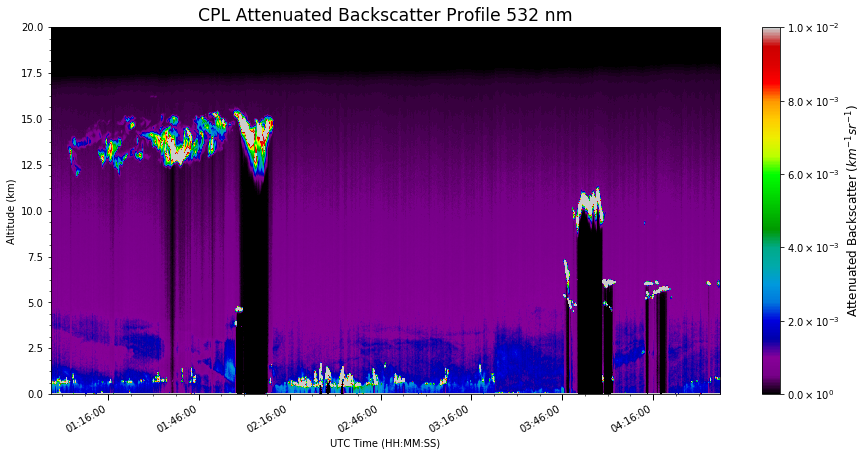

In [5]:
Bin_index = np.where((Bin_Alt[:] >= 0)) #Removing values sampled below 0 km altitude
index = np.max(Bin_index)
fig = plt.figure(figsize=(15,7.5))
ax = fig.add_subplot(111)
grid = grid[:,::-1]

grid = grid[:,(900-index):]
ax.xaxis_date()
ax.minorticks_on()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
cmap = cm.get_cmap('nipy_spectral') #Choose a desired colormap


#Creating a 2-D pixelplot, the range of time can be set by changing the indices of the x_lims 
ax_temp = ax.imshow(grid.T, extent=[x_lims[0],x_lims[-1],Bin_Alt[index],Bin_Alt.max()], origin = 'lower',
           interpolation='bilinear', vmin=0, vmax=1E-2,cmap=cmap,  aspect= 'auto')


#Set plot text parameters.  
matplotlib.rcParams.update({'font.size': 12}) #The default font size is 12, which is = 'medium'.  Change value to liking. 
params = {'legend.fontsize': 'small', #Set font sizes in relation to medium (12 for this case)
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}

plt.rcParams.update(params)
ax.tick_params(axis='x',length = 6, width = 1.0, color = 'black')
ax.set_ybound(0, 20) #Y-axis limit in km altitude, for this plot it is set from 0-20 km


#Creating plot labels
ax.set_xlabel('UTC Time (HH:MM:SS)')
ax.set_ylabel('Altitude (km)')
ax.set_title('CPL Attenuated Backscatter Profile 532 nm') #Change title to reflect plotted wavelength
ax.legend()

fig.autofmt_xdate() #tilt x-axis labels 45 degrees


#Function formats the color bar tick labels into standard scientific notation format
def sci_not_fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


#Plot the colorbar
cbar = colorbar(mappable=ax_temp,  format=mticker.FuncFormatter(sci_not_fmt))  #Tick labels formated in scientific notation, references function above 
cbar.set_label('Attenuated Backscatter ($km^{-1}sr^{-1}$)', rotation=90,fontsize='medium')  #The color bar label is rotated 

plt.show() #Display plot

# For science analysis, refer to the dataset documentation to employ additional quality control measures. This plotting code does not account for flag information stored within the data files.

